# No Scrubs Text Analysis
__Author:__ Sara Riker  
__Date:__ December 27, 2020

---


In [1]:
# install packages
%matplotlib inline

import pandas as pd
import numpy as np
import emojis
import emoji
import regex
import re
import collections
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS 

## Get Data

In [2]:
messages = pd.read_csv('messages_no_scrubs.csv')
messages.head()

,Chat Session,message_date,Deliver_date,read_date,service,type,sender_id,sender_name,status,subject,text,attachment,attachmen_type
0,No Scrubs,12/27/19 14:21,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,NaN,IMG_2805.HEIC,Image
1,No Scrubs,12/27/19 14:21,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,My dad is currently telling Milo about all the...,NaN,NaN
2,No Scrubs,12/27/19 14:22,NaN,12/27/19 14:22,iMessage,Incoming,1.917829e+10,Melissa Ross,Read,NaN,🤣🤣 also he got so big!!!,NaN,NaN
3,No Scrubs,12/27/19 14:22,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,Liked “🤣🤣 also he got so big!!! ”,NaN,NaN
4,No Scrubs,12/27/19 14:23,NaN,12/27/19 14:23,iMessage,Incoming,1.610662e+10,Claire Soloman,Read,NaN,HAMBURGER,NaN,NaN


## Clean Data

In [3]:
# my messages don't have sender names
messages.sender_name = messages.sender_name.fillna('Sara Riker')

#Images show as null in text
messages['message'] = np.where(messages["text"].isnull(), messages["attachmen_type"], messages["text"] )

#tapbacks
tapbacks = ['Liked', 'Loved', 'Laughed', 'Emphasized', 'Disliked']
messages['tapback'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], "")
messages['message'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], messages['message'])
messages['date'] = messages['message_date'].str.split().str[0]
messages['time'] = messages['message_date'].str.split().str[1]

# Emojis
#messages['emoji'] = messages_final['message'].apply(lambda x: emojis.get(x))

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

messages["emoji"] = messages["message"].apply(split_count)

#only columns I care about 
messages_final = messages[['date', 'time', 'sender_name', 'message', 'tapback', 'emoji']]


In [4]:
messages_final.head()

,date,time,sender_name,message,tapback,emoji
0,12/27/19,14:21,Sara Riker,Image,,[]
1,12/27/19,14:21,Sara Riker,My dad is currently telling Milo about all the...,,[😂]
2,12/27/19,14:22,Melissa Ross,🤣🤣 also he got so big!!!,,"[🤣, 🤣]"
3,12/27/19,14:22,Sara Riker,Liked,Liked,[]
4,12/27/19,14:23,Claire Soloman,HAMBURGER,,[]


In [5]:


total_messages = messages_final.shape[0]
media_messages = messages_final[messages_final['message'] == '<Media omitted>'].shape[0]
messages_final["emoji_2"] = messages_final["message"].apply(split_count)
emojis = sum(messages_final['emoji_2'].str.len())
URLPATTERN = r'(https?://\S+)'
#df['urlcount'] = messages_final.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
#links = np.sum(messages_final.urlcount)

# Emojis

In [6]:
total_emojis_list = list([a for b in messages_final.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,282
1,❤️,247
2,🤣,184
3,🤷‍♀️,97
4,🤦🏼‍♀️,84
...,...,...
112,💙,1
113,🦃,1
114,🤗,1
115,🎁,1


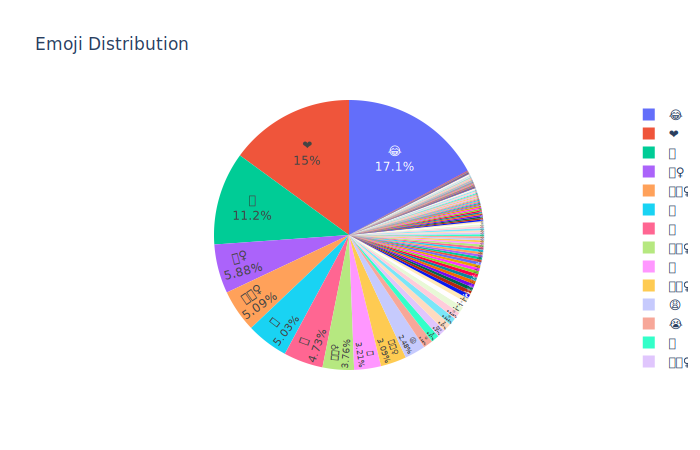

In [7]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

Emoji Distribution for Sara Riker


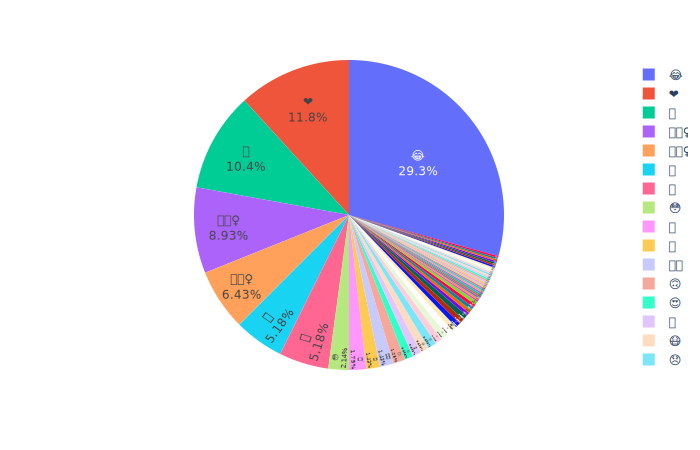

Emoji Distribution for Melissa Ross


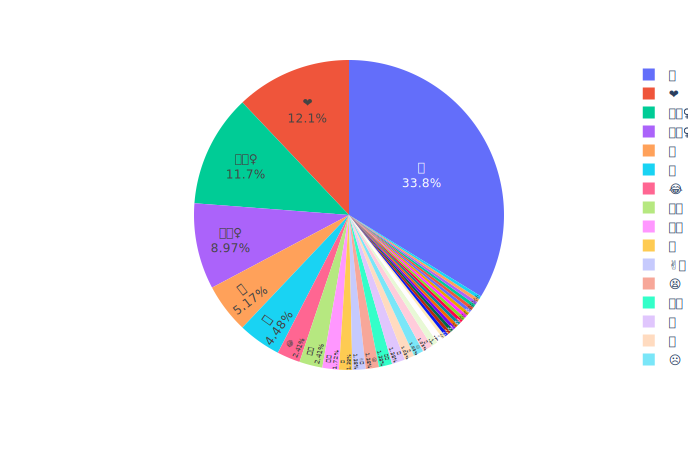

Emoji Distribution for Claire Soloman


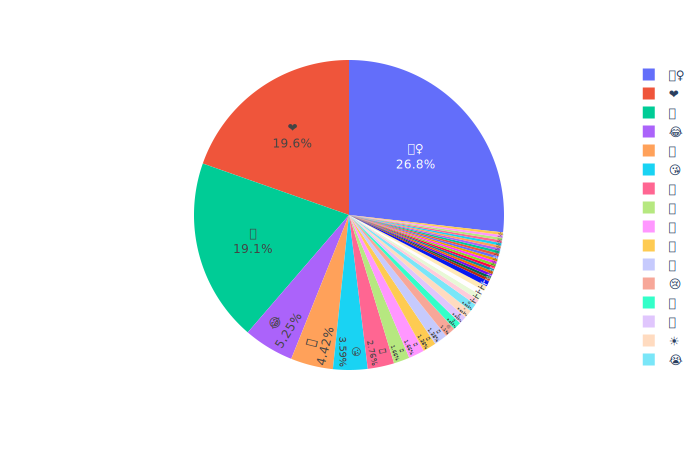

Emoji Distribution for Jess Thorn


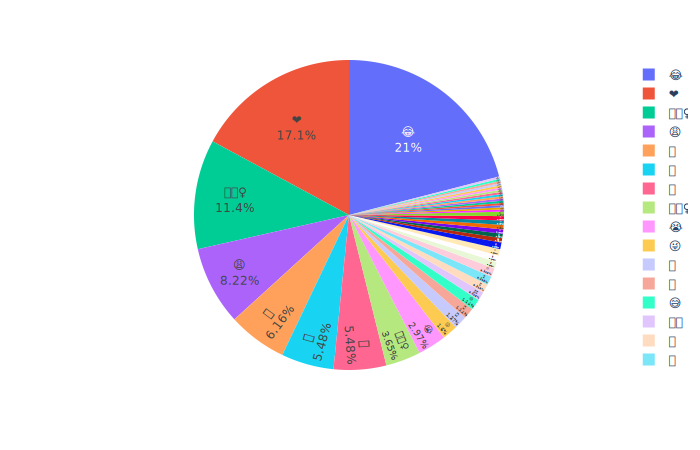

In [8]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_final.sender_name.unique()
for i in range(len(l)):
  dummy_df = messages_final[messages_final['sender_name'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(collections.Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show(renderer="svg")

# Words

In [11]:
just_text = messages_final[messages_final['tapback'] == '']
just_text = just_text[just_text['message'] != 'Image']
text = " ".join(review for review in just_text.message)
print ("There are {} words in all the messages.".format(len(text)))

There are 987930 words in all the messages.


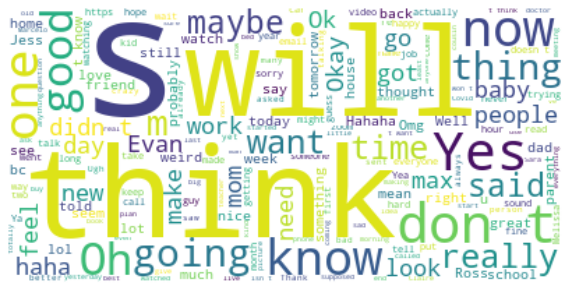

In [12]:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()